In [1]:
import os, sys, inspect, io

cmd_folder = os.path.realpath(
    os.path.dirname(
        os.path.abspath(os.path.split(inspect.getfile( inspect.currentframe() ))[0])))

if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder)
    
from transitions import *
from transitions.extensions import GraphMachine
from IPython.display import Image, display, display_png

class Matter(object):
    def alert(self):
        pass
    
    def resume(self):
        pass
    
    def notify(self):
        pass
    
    def is_valid(self):
        return True
    
    def is_not_valid(self):
        return False
    
    def is_also_valid(self):
        return True
    
    # graph object is created by the machine
    def show_graph(self, **kwargs):
        g = self.get_graph(**kwargs).generate()
        g.attr(size='8.5')
        return g
        
extra_args = dict(auto_transitions=False, initial='solid', title='Matter is Fun!',
                  show_conditions=True, show_state_attributes=True)

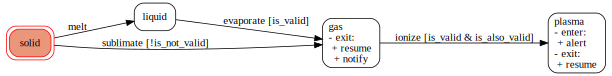

In [2]:
transitions = [
    { 'trigger': 'melt', 'source': 'solid', 'dest': 'liquid' },
    { 'trigger': 'evaporate', 'source': 'liquid', 'dest': 'gas', 'conditions':'is_valid' },
    { 'trigger': 'sublimate', 'source': 'solid', 'dest': 'gas', 'unless':'is_not_valid' },
    { 'trigger': 'ionize', 'source': 'gas', 'dest': 'plasma', 
      'conditions':['is_valid','is_also_valid'] }
]
states=['solid', 'liquid', {'name': 'gas', 'on_exit': ['resume', 'notify']},
        {'name': 'plasma', 'on_enter': 'alert', 'on_exit': 'resume'}]

model = Matter()
machine = GraphMachine(model=model, states=states, transitions=transitions, **extra_args)
model.show_graph()

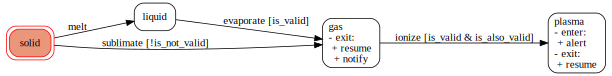

In [3]:
machine.show_auto_transitions = False # hide auto transitions
model.show_graph(force_new=True) # rerender graph

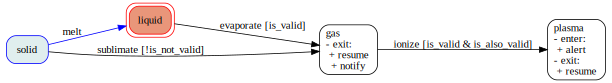

In [4]:
model.melt()
model.show_graph()

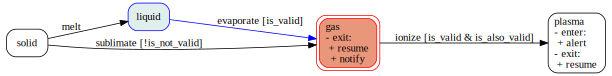

In [5]:
model.evaporate()
model.show_graph()

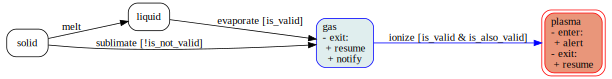

In [6]:
model.ionize()
model.show_graph()

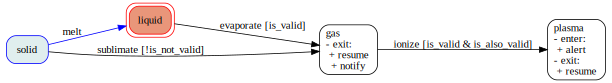

In [7]:
# multimodel test
model1 = Matter()
model2 = Matter()
machine = GraphMachine(model=[model1, model2], states=states, transitions=transitions, **extra_args)
model1.melt()
model1.show_graph()

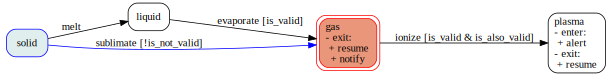

In [8]:
model2.sublimate()
model2.show_graph()

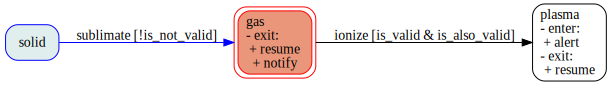

In [9]:
# show only region of interest which is previous state, active state and all reachable states
model2.show_graph(show_roi=True)

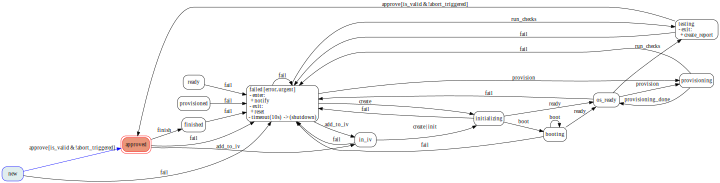

In [10]:
from transitions.extensions.states import Timeout, Tags, add_state_features

@add_state_features(Timeout, Tags)
class CustomMachine(GraphMachine):
    pass


states = ['new', 'approved', 'ready', 'finished', 'provisioned',
          {'name': 'failed', 'on_enter': 'notify', 'on_exit': 'reset',
           'tags': ['error', 'urgent'], 'timeout': 10, 'on_timeout': 'shutdown'},
          'in_iv', 'initializing', 'booting', 'os_ready', {'name': 'testing', 'on_exit': 'create_report'},
          'provisioning']

transitions = [{'trigger': 'approve', 'source': ['new', 'testing'], 'dest':'approved',
                'conditions': 'is_valid', 'unless': 'abort_triggered'},
               ['fail', '*', 'failed'],
               ['add_to_iv', ['approved', 'failed'], 'in_iv'],
               ['create', ['failed','in_iv'], 'initializing'],
               ['init', 'in_iv', 'initializing'],
               ['finish', 'approved', 'finished'],
               ['boot', ['booting', 'initializing'], 'booting'],
               ['ready', ['booting', 'initializing'], 'os_ready'],
               ['run_checks', ['failed', 'os_ready'], 'testing'],
               ['provision', ['os_ready', 'failed'], 'provisioning'],
               ['provisioning_done', 'provisioning', 'os_ready']]

class Model():
    def is_valid(self):
        return True
    
    def abort_triggered(self):
        return False
    
    def show_graph(self, **kwargs):
        g = self.get_graph(**kwargs).generate()
        g.attr(size='10')
        return g
extra_args['title'] = "System State"
extra_args['initial'] = "new"
model = Model()
machine = CustomMachine(model=model, states=states, transitions=transitions, **extra_args)
model.approve()
model.show_graph()